# Model Evaluation And Refinement

We have built models and made predictions of vehicle prices. Now it's time to determine how accurate these predictions are.

In [0]:
#importing the necessary libraries
import pandas as pd
import numpy as np

from IPython.display import display
from IPython.html import widgets 
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [0]:
# Import clean data 
path = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DA0101EN/module_5_auto.csv'
df = pd.read_csv(path)

In [0]:
df.to_csv('module_5_auto.csv')

In [0]:
#First lets only use numeric data
df=df._get_numeric_data()
df.head()

,Unnamed: 0,Unnamed: 0.1,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,...,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,0,0,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,0,1
1,1,1,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,0,1
2,2,2,1,122,94.5,0.822681,0.909722,52.4,2823,152,...,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,0,1
3,3,3,2,164,99.8,0.848630,0.919444,54.3,2337,109,...,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,0,1
4,4,4,2,164,99.4,0.848630,0.922222,54.3,2824,136,...,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,0,1


In [0]:
#defining functions to later on use for plotting
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

In [0]:
#defining functions to later on use for plotting
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
 
    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

## Training and Testing

An important step in testing your model is to split your data into training and testing data. We will place the target data price in a separate dataframe y:

In [0]:
y_data = df['price']

In [0]:
#Drop price data in x data
x_data=df.drop('price',axis=1)

We randomly split our data into training and testing data using the function `train_test_split`. The `test_size` parameter sets the proportion of data that is split into the testing set. In our example, the testing set is set to 10% of the total dataset.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 31
number of training samples: 170


In [0]:
#Create a Linear Regression object
lre=LinearRegression()

In [0]:
#Fit the model using the feature horsepower
lre.fit(x_train[['horsepower']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
 #Calculate the R^2 on the test data
lre.score(x_test[['horsepower']], y_test)

0.707688374146705

In [0]:
 #Calculate the R^2 on the train data
lre.score(x_train[['horsepower']], y_train)

0.6449517437659684

We can see the R^2 is much smaller using the test data.

Sometimes we do not have sufficient testing data; as a result, we may want to perform Cross-validation. For this purpose, we input the object, the feature in this case ' horsepower', the target data (y_data). The parameter 'cv' determines the number of folds; in this case 4.
The default scoring is R^2; each element in the array has the average R^2 value in the fold

In [0]:
Rcross = cross_val_score(lre, x_data[['horsepower']], y_data, cv=4)
Rcross

array([0.7746232 , 0.51716687, 0.74785353, 0.04839605])

We can calculate the average and standard deviation of our estimate

In [0]:
#mean and st. dev of the estimates
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.522009915042119 and the standard deviation is 0.291183944475603


We can use negative squared error as a score by setting the parameter 'scoring' metric to 'neg_mean_squared_error'

In [0]:
#using negative mean squared error
-1 * cross_val_score(lre,x_data[['horsepower']], y_data,cv=4,scoring='neg_mean_squared_error')

array([20254142.84026702, 43745493.2650517 , 12539630.34014931,
       17561927.72247591])

We can also use the function `cross_val_predict` to predict the output. The function splits up the data into the specified number of folds, using one fold to get a prediction while the rest of the folds are used as test data. <br/> We input the object, the feature in this case 'horsepower' , the target data y_data. The parameter 'cv' determines the number of folds; in this case 4.

In [0]:
yhat = cross_val_predict(lre,x_data[['horsepower']], y_data,cv=4)
yhat[0:5]

array([14141.63807508, 14141.63807508, 20814.29423473, 12745.03562306,
       14762.35027598])

## Overfitting, Underfitting and Model Selection

It turns out that the test data sometimes referred to as the out of sample data is a much better measure of how well your model performs in the real world. One reason for this is overfitting. <br/> 

**Overfitting** occurs when the model fits the noise, not the underlying process. Therefore when testing your model using the test-set, your model does not perform as well as it is modelling noise, not the underlying process that generated the relationship.  <br/>

These differences are more apparent in Multiple Linear Regression and Polynomial Regression, hence, we will explore overfitting in that context.

In [0]:
#create Multiple linear regression objects
lr = LinearRegression()
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
#Prediction using training data
yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_train[0:5]

array([11927.70699817, 11236.71672034,  6436.91775515, 21890.22064982,
       16667.18254832])

In [0]:
#Prediction using test data
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_test[0:5]

array([11349.16502418,  5914.48335385, 11243.76325987,  6662.03197043,
       15555.76936275])

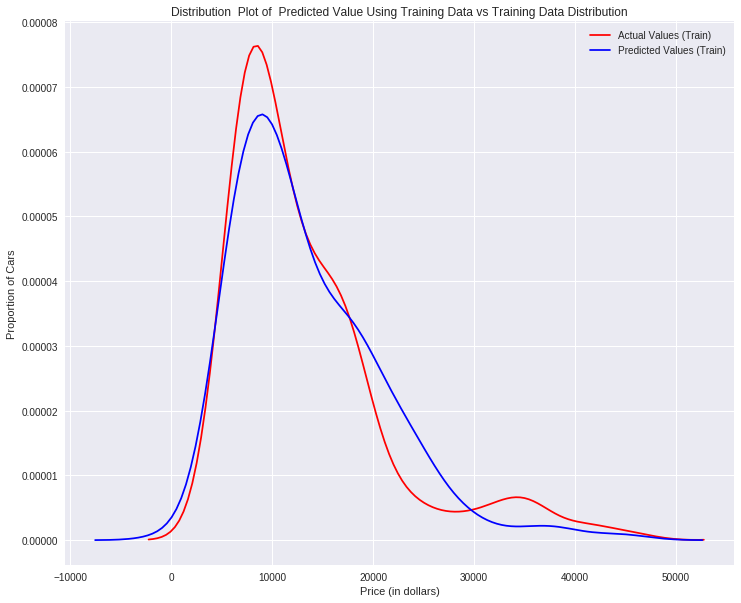

In [0]:
#Examine the distribution of the predicted values of the training data
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

So far the model seems to be doing well in learning from the training dataset. But what happens when the model encounters new data from the testing dataset? When the model generates new values from the test data, we see the distribution of the predicted values is much different from the actual target values.

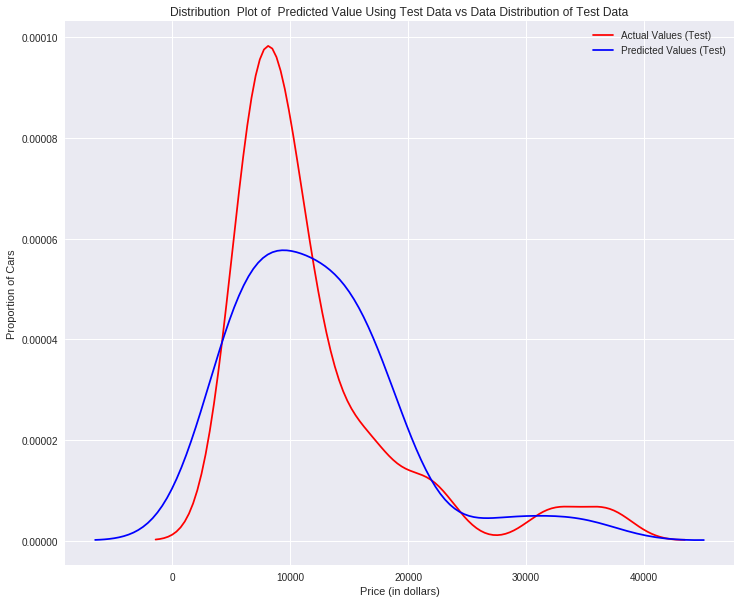

In [0]:
#Examine the distribution of the predicted values of the test data
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

Comparing Figure 1 and Figure 2; it is evident the distribution of the test data in Figure 1 is much better at fitting the data. This difference in Figure 2 is apparent where the ranges are from 5000 to 15 000. This is where the distribution shape is exceptionally different. 

We can evaluate to see if polynomial regression also exhibits a drop in the prediction accuracy when analysing the test dataset.overfitting of polynomials

In [0]:
#split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

In [0]:
#Perform a degree 5 polynomial transformation
pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])
pr

PolynomialFeatures(degree=5, include_bias=True, interaction_only=False)

In [0]:
#Create a linear regression model "poly" and train it.
poly = LinearRegression()
poly.fit(x_train_pr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
#See the output of the prediction model
yhat = poly.predict(x_test_pr)
yhat[0:5]

array([ 6728.65561887,  7307.98782321, 12213.78770965, 18893.24804015,
       19995.95195136])

In [0]:
# take the first five predicted values and compare it to the actual targets.
print("Predicted values:", yhat[0:4])
print("True values:", y_test[0:4].values)

Predicted values: [ 6728.65561887  7307.98782321 12213.78770965 18893.24804015]
True values: [ 6295. 10698. 13860. 13499.]


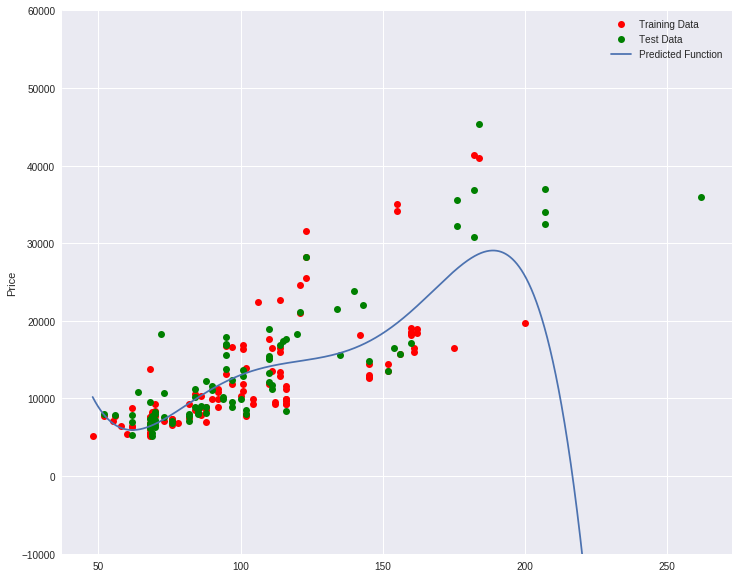

In [0]:
#Display the training data, testing data, and the predicted function.
PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly,pr)

Figur 4 A polynomial regression model, red dots represent training data, green dots represent test data, and the blue line represents the model prediction.

We see that the estimated function appears to track the data but around 200 horsepower, the function begins to diverge from the data points.

In [0]:
#R^2 of the training data
poly.score(x_train_pr, y_train)

0.556771690212023

In [0]:
#R^2 of the test data:
poly.score(x_test_pr, y_test)

-29.871340302044153

We see the R^2 for the training data is 0.5567 while the R^2 on the test data was -29.87. The lower the R^2, the worse the model, a Negative R^2 is a sign of overfitting.

Text(3, 0.75, 'Maximum R^2 ')

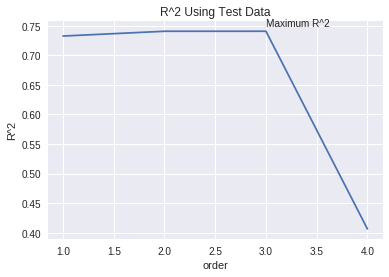

In [0]:
# see how the R^2 changes on the test data for different order polynomials and plot the results
Rsqu_test = []

order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    
    x_test_pr = pr.fit_transform(x_test[['horsepower']])    
    
    lr.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test))

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')    

We see the R^2 gradually increases until an order three polynomial is used. Then the R^2 dramatically decreases at four.

In [0]:
def f(order, test_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_data, random_state=0)
    pr = PolynomialFeatures(degree=order)
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    x_test_pr = pr.fit_transform(x_test[['horsepower']])
    poly = LinearRegression()
    poly.fit(x_train_pr,y_train)
    PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train,y_test, poly, pr)

In [0]:
interact(f, order=(0, 6, 1), test_data=(0.05, 0.95, 0.05))

interactive(children=(IntSlider(value=3, description='order', max=6), FloatSlider(value=0.45, description='tes…

<function __main__.f>

We can perform polynomial transformations with more than one feature

In [0]:
#Create a "PolynomialFeatures" object 
pr1=PolynomialFeatures(degree=2)

In [0]:
#Transform the training and testing samples for the chosen features
x_train_pr1=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

x_test_pr1=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

In [0]:
#Create a linear regression model and train the object
poly1=LinearRegression().fit(x_train_pr1,y_train)

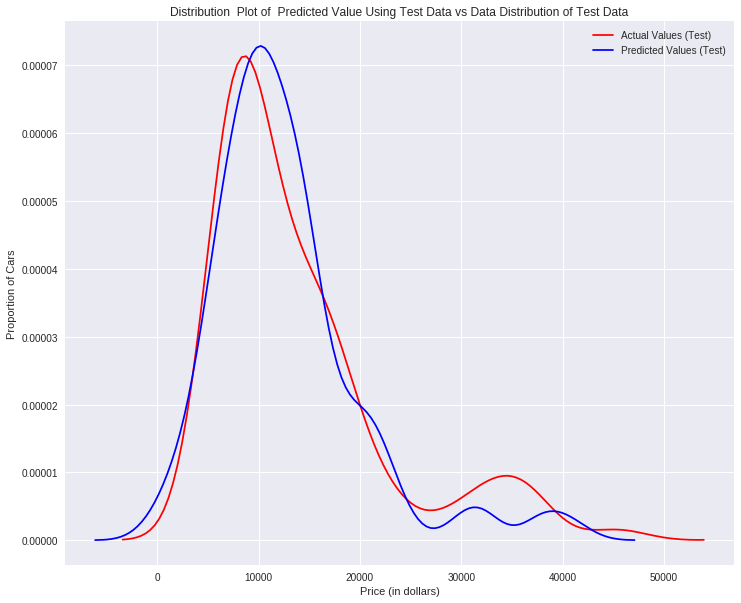

In [0]:
#Predict an output on the polynomial features 
yhat_test1=poly1.predict(x_train_pr1)

#Display the distribution of the predicted output vs the test data
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test, yhat_test1, "Actual Values (Test)", "Predicted Values (Test)", Title)

**Underfitting** <br/>

When the model cannot capture the underlying trend of the data. In this case, we observe **underfitting**. 

**Ridge Regression**
 
For example, in prediction model, the estimated polynomial coefficients have a very large magnitude. Ridge regression controls the magnitude of these polynomial coefficients by introducing the parameter **alpha**. Alpha is a parameter we select before fitting or training the model.
<br/>
If alpha is too large, the coefficients will approach zero and under-fit the data. If alpha is zero, the over-fitting is evident. In order to select alpha we use cross-validation.


In [0]:
#Perform a polynomial transformation
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])
x_test_pr=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])

In [0]:
#Create a Ridge regression object, setting the regularization parameter to 0.1
RigeModel=Ridge(alpha=0.1)

In [0]:
#Fit the model
RigeModel.fit(x_train_pr, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.029716e-16
  overwrite_a=True).T


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
#Obtain a prediction
yhat = RigeModel.predict(x_test_pr)

In [0]:
#Compare the predicted samples to our test set
print('predicted:', yhat[0:4])
print('test set :', y_test[0:4].values)

predicted: [ 6567.83081933  9597.97151399 20836.22326843 19347.69543463]
test set : [ 6295. 10698. 13860. 13499.]


In [0]:
#Select the value of Alfa that minimizes the test error with a for loop
Rsqu_test = []
Rsqu_train = []
dummy1 = []
ALFA = 10 * np.array(range(0,1000))
for alfa in ALFA:
    RigeModel = Ridge(alpha=alfa) 
    RigeModel.fit(x_train_pr, y_train)
    Rsqu_test.append(RigeModel.score(x_test_pr, y_test))
    Rsqu_train.append(RigeModel.score(x_train_pr, y_train))

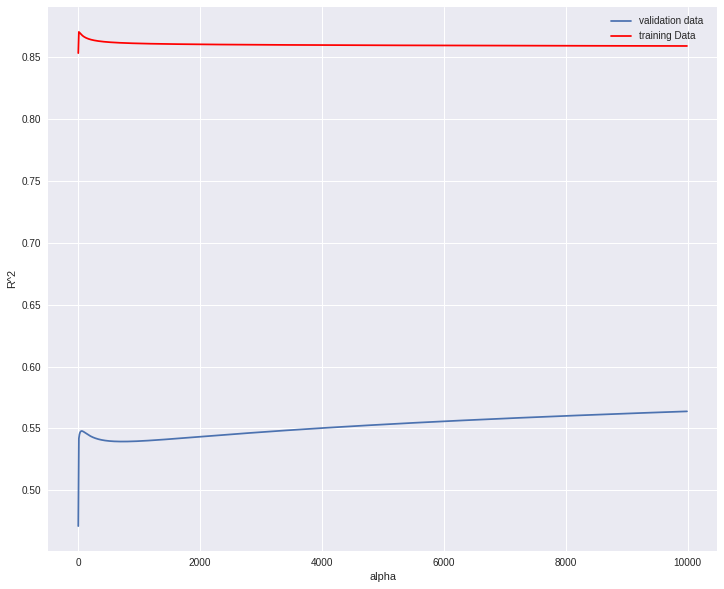

In [0]:
#Plot out the value of R^2 for different Alphas
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(ALFA,Rsqu_test, label='validation data  ')
plt.plot(ALFA,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

The red line in the figure above represents the R^2 of the test data, as Alpha increases the R^2 decreases; therefore as Alfa increases the model performs worse on the test data. The blue line represents the R^2 on the validation data, as the value for Alfa increases the R^2 decreases.

**Grid Search** 

Parameters like the alpha term discussed in the previous video are not part of the fitting
or training process. These values are called hyperparameters. Grid search allows us to scan through multiple free parameters with few lines of code and perform cross-validation.

In [0]:
#Create a dictionary of parameter values
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000],'normalize':[True,False]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000],
  'normalize': [True, False]}]

In [0]:
#Create a ridge regions object
RR=Ridge()
RR

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
#Create a ridge grid search object
Grid1 = GridSearchCV(RR, parameters1,cv=4)

In [0]:
#Fit the model
Grid1.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000], 'normalize': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
#Find the best parameter values on the validation data
BestRR=Grid1.best_estimator_
BestRR

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [0]:
#Test our model on the test data
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.840859719294301

In [0]:
CVresults = Grid1.cv_results_
CVresults